# Task 3: Helper notebook for loading the data and saving the predictions

In [4]:
import pickle
import gzip
import numpy as np
import os

In [5]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF

### Helper functions

In [6]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [7]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [8]:
def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)

        assert target.shape == prediction.shape
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    print("Median IOU: ", np.median(ious))

### Load data

In [9]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

In [10]:
num_exp = 0
for d in train_data:
#     v = d['video']
#     fr = d['frames']
    if d['dataset'] == 'expert':
        num_exp+=1
#     print(np.shape(v))
#     print(fr)
print(len(train_data))
print(num_exp)

65
19


In [53]:
print(train_data[55]['frames'])

[20, 34, 68]


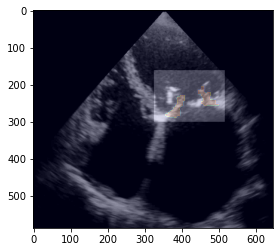

In [57]:
l1 = train_data[55]['label'][:,:,68]
d1 = train_data[55]['video'][:,:,68]
b1 = train_data[55]['box']
plt.imshow(d1, cmap='gray')
plt.imshow(b1,cmap='gray',alpha = 0.3)
plt.imshow(l1, cmap='jet',alpha = 0.15)

In [30]:
d1 = train_data[55]['video']
v = np.vstack(d1)
np.shape(v)

(379789, 76)

In [38]:
np.shape(d1)

(587, 647, 76)

In [31]:
X = [1,2,3]
a = np.linalg.norm(X)
print(a)

3.7416573867739413


In [32]:
1e-10

1e-10

# RNMF

In [33]:
class RobustNMF:



    def initialize_WH(self,X,k):

        model = NMF(n_components=2, init='random', random_state=0)
        W = model.fit_transform(X)
        H = model.components_
        W[W < 1e-10] = 1e-10
        H[H < 1e-10] = 1e-10
        return W,H


    def __init__(self,X,k,lamda,maxiter):

        self.X = X
        self.X_shape = X.shape
        self.k = k
        self.lamda = lamda
        self.maxiter = maxiter

        self.W , self.H = self.initialize_WH(X,k)
        #self.S = np.zeros(X.shape)


    def update_S(self,S,X_shape,lamda,p):
        for i in range(X_shape[0]):
            for j in range(X_shape[1]):
                if S[i][j] + lamda*p[i][j] > lamda:
                    S[i][j] = S[i,j] + lamda*p[i][j] - lamda
                else:
                    S[i][j] = 0.0
        return S
    
    def update_p(self,X,W,H,S,lamda,p):
        print(np.shape(p))
        return p + (1/lamda)*((X - np.dot(W,H)) - S)

    def update_W(self,X,W,H,S):

        numerator = np.abs(np.dot(S-X,H.T)) - np.dot(S-X,H.T)
        denominator = 2 * np.dot(np.dot(W,H),H.T)
#         for i in range(len(W)):
#             for j in range(len(W[0])):
#                 W[i][j] = (numerator[i][j]/denominator[i][j])*W[i][j]

#         return W
        return (numerator/denominator)*W

    def update_H(self,X,W,H,S):

        numerator = np.abs(np.dot(W.T,S-X)) - np.dot(W.T,S-X)
        denominator = 2 * np.dot(np.dot(W.T,W),H)
        
#         for i in range(len(H)):
#             for j in range(len(H[0])):
#                 H[i][j] = (numerator[i][j]/denominator[i][j])*H[i][j]

#         return H
        return (numerator/denominator)*H 

    def compute_p(self, S):
        s = np.sign(S)
        print(s[0])
        for i in range(len(s)):
            for j in range(len(s[0])):
                s[i][j] = max(0, s[i][j])
        s = s+np.linalg.norm(S)
        return s
    
    def normalize(self,W,H):

        W_square = np.power(W, 2)
        norm = np.sum(W_square, axis=0)
        W = W / norm
        H_T = H.T
        H_T = H_T * norm
        H = H_T.T
        return W, H

    def rnmf(self):

        X = self.X
        W = self.W
        H = self.H


        maxiter = self.maxiter
        lamda = self.lamda

        S = X - np.dot(W,H)
        p = S

        for iter in range(maxiter):

            S = X - np.dot(W,H)
                       
            S = self.update_S(S,X.shape,lamda,p)
            p = self.update_p(X,W,H,S,lamda,p)
            W = self.update_W(X,W,H,S)
            W[W < 1e-10] = 1e-10
            H = self.update_H(X,W,H,S)
            H[H < 1e-10] = 1e-10
            W, H = self.normalize(W,H)

        
        self.W = W
        self.H = H
        self.S = S


    def rmse(self):

        X = self.X
        W = self.W
        H = self.H
        S = self.S

        rmse = np.sqrt(mean_squared_error(X, np.dot(W,H)+S))

        return rmse

In [34]:
print(np.shape(v))

(379789, 76)


In [35]:
model = RobustNMF(v,2,0.1,10)
model.rnmf()

(379789, 76)
(379789, 76)
(379789, 76)
(379789, 76)
(379789, 76)
(379789, 76)
(379789, 76)
(379789, 76)
(379789, 76)
(379789, 76)


In [36]:
w = model.W
h = model.H
s = model.S

In [49]:
w_split = np.array(np.vsplit(np.dot(w,h),587))
print(np.shape(w_split[:,:,0]))

(587, 647)


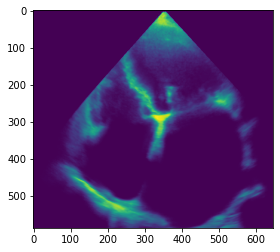

In [51]:
plt.imshow(w_split[:,:,0])

In [40]:
s_split = np.vsplit(s,587)
print(np.shape(s_split))
s_split = np.array(s_split)
s1 = s_split[:,:,0]
print(np.shape(s1))

(587, 647, 76)
(587, 647)


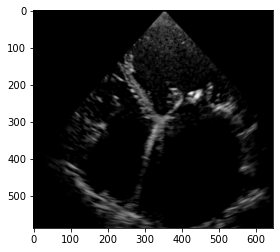

In [41]:
plt.imshow(s1, cmap='gray')

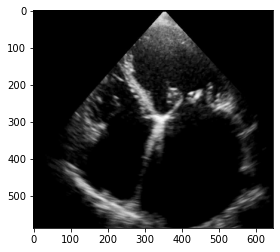

In [42]:
plt.imshow(d1[:,:,0], cmap='gray')

In [5]:
from scipy import sparse
import numpy as np
import scipy

In [ ]:
class segmenter:

    def __init__(self,lambda1,lambda2,lambda3,WH,S,x,y,z):

        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        self.WH = WH
        self.S = S
        self.x, self.y, self.z = x,y,z
        (D1,D2,self.Dt) = self.forward_difference()
        self.DXY = np.concatenate(D1,D2,axis=0)
        self.sigmaM = 0.8 / scipy.linalg.interpolative.estimate_spectral_norm(np.concatenate(D1,D2,self.Dt), axis=0) # TODO
        self.TV = [0.04] # lambda2
        self.TVT = [0] # lambd3
        self.threshold = [0.5] # todo 
        self.t = [0.01]


    def forward_difference(self):

        D1 = sparse.eye(self.x)
        row1 = np.array(range(1,self.x)) #  sparse(1:n,max(1,0:n-1),-1,n,n);
        col1 = np.array(range(0,self.x-1))
        val1 = np.repeat(-1,self.x-1)
        D1 = D1 + sparse.csr_matrix((val1, (row1,col1)), shape=(self.x,self.x))
        D1 = sparse.kron(sparse.eye(self.x), D1)

        D2 = sparse.eye(self.y)
        row2 = np.array(range(0,self.y-1))
        col2 = np.array(range(1,self.y))
        val2 = np.repeat(-1,self.y-1)
        D2 = D2 + sparse.csr_matrix((val2, (row2,col2)), shape=(self.y,self.y))
        D2 = sparse.kron(np.transpose(D2),sparse.eye(self.y))

        D3 = sparse.eye(self.z)
        row3 = np.array(range(0,self.z-1))
        col3 = np.array(range(1,self.z))
        val3 = np.repeat(-1,self.z-1)
        D3 = D2 + sparse.csr_matrix((val3, (row3,col3)), shape=(self.z,self.z))
        D3 = sparse.kron(np.transpose(D3),sparse.eye(self.x*self.y))

        D1 = sparse.kron(sparse.eye(self.z), D1)
        D2 = sparse.kron(sparse.eye(self.z), D2)

        return (D1,D2,D3)


    def conjugateL2(self, lamb, data):
        #self.S = np.zeros(X.shape)
        norm = np.linalg.norm(data)

        if (norm > lamb):
            data= data*lamb / norm
        
        return data

    def iterate(self):
        p1,p2 = self.S,self.S
        p1[:] = [0]
        p2[:] = [0]
        M = np.vstack(self.S)
        Sp = M
        for i in range(self.iter):
           p1 = p1 + self.sigmaM * self.DXY * M
           p1 = self.conjugateL2(self.VT,p1)
           p2 = min(max(p2 + self.sigmaM * self.DT * M, -self.TVT),self.TVT)

           M_old = M
           M = M - self.sigmaM * np.transpose(self.DXY) * p1 - self.sigmaM * np.transpose(self.DT) * p2 - self.sigmaM * self.lambda1 * (self.t - Sp) - self.sigmaM * self.threshold * self.WH - self.sigmaM * self.lambda2 * 1
        
           M = min(max(M,0),1)
           M = 2 * M - M_old
    






### make predictions and save prediction in correct format

In [8]:
# make prediction for test
predictions = []
for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=bool) # TO_DO: predict
    height = prediction.shape[0]
    width = prediction.shape[1]
    prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

In [20]:
arr = np.array(predictions[0]['prediction'])
print(arr.shape[2])

84


In [9]:
# save in correct format
save_zipped_pickle(predictions, 'my_predictions.pkl')